In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Get current working directory
cwd = os.getcwd()

def load_file(filepath: str) -> pd.DataFrame:
    # Check if file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError("File not found")
    
    # Read file
    try:
        df = pd.read_csv(filepath, skiprows=2, header=0, sep=",", decimal=".")
    except:
        return None
    

    # Make new column with entire filepath, and another with just the filename
    df["filepath"] = '/'.join(filepath.split(os.sep)[-2:])
    df["filename"] = os.path.basename(filepath)
    df["label"] = filepath.split(os.sep)[-2].split("-")[-1]

    return df

def get_all_data(data_folder) -> pd.DataFrame:
    # Check if folder exists
    if not os.path.exists(data_folder):
        raise FileNotFoundError("Folder not found")

    # Check if cwd is part of data_folder
    if not data_folder.startswith(cwd):
        # If not, add cwd to data_folder
        data_folder = os.path.join(cwd, data_folder)

    # Get all csv files from subfolders of data_folder
    dfs = []
    for root, dirs, filenames in os.walk(data_folder):
        for f in filenames:
            if f.endswith(".CSV") and not "Merged" in f:
                df = load_file(os.path.join(root, f))
                if df is not None:
                    dfs.append(df)
    
    # Concatenate all dataframes
    df = pd.concat(dfs, ignore_index=True)
    return df
    

## Load data

In [3]:
# Load data
df = get_all_data("../../data/raw")

### Simple stats

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4189920 entries, 0 to 4189919
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   millis    int64  
 1   x         float64
 2   y         float64
 3   z         float64
 4   filepath  object 
 5   filename  object 
 6   label     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 223.8+ MB


In [5]:
df.head()

,millis,x,y,z,filepath,filename,label
0,8028,-0.26,1.76,0.77,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
1,8028,-0.31,1.32,0.82,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
2,8028,0.03,1.18,1.01,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
3,8028,-0.26,1.52,0.77,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
4,8028,-0.07,1.32,0.72,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting


In [6]:
df.label.value_counts()

Broken_Cutting     1419600
Missing_Idle        898800
Healthy_Cutting     663600
Healthy_Idle        633360
Broken_Idle         299040
Missing_Cutting     275520
Name: label, dtype: int64

In [7]:
df.groupby(["label", "filename"]).size().reset_index(name="count")

,label,filename,count
0,Broken_Cutting,Test 10 (1).CSV,13440
1,Broken_Cutting,Test 10 (2).CSV,26040
2,Broken_Cutting,Test 10 (3).CSV,670320
3,Broken_Cutting,Test 10 - Merged.CSV,709800
4,Broken_Idle,Test 09 (1).CSV,2520
5,Broken_Idle,Test 09 (14).CSV,5040
6,Broken_Idle,Test 09 (15).CSV,85680
7,Broken_Idle,Test 09 (2).CSV,10080
8,Broken_Idle,Test 09 (27).CSV,840
9,Broken_Idle,Test 09 (59).CSV,1680


In [8]:
# Save data to processed folder
df.to_parquet("../../data/processed/processed.parquet")
del df

### Load data from processed

In [9]:
# Load data from processed
df = pd.read_parquet("../../data/processed/processed.parquet")
df.head()

,millis,x,y,z,filepath,filename,label
0,8028,-0.26,1.76,0.77,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
1,8028,-0.31,1.32,0.82,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
2,8028,0.03,1.18,1.01,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
3,8028,-0.26,1.52,0.77,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting
4,8028,-0.07,1.32,0.72,Test 6-Healthy_Cutting/Test 6.CSV,Test 6.CSV,Healthy_Cutting


## Split data in train and test

In [10]:
def split_grouped_data(df: pd.DataFrame, n_splits: int = 2, time_series_splitter: TimeSeriesSplit = TimeSeriesSplit()) -> list:
    # Drop columns that are not needed
    df = df.drop(columns=["millis", "filepath", "filename"])

    # Split into train and test
    train_splits, test_splits = time_series_splitter.split(df)
    return train_splits, test_splits

def split_data(df: pd.DataFrame, n_splits: int = 2, groupby_cols=["filename"]) -> list:
    # Split into train and test for each group
    train_splits, train_labels, test_splits, test_labels = [], [], [], []
    tss = TimeSeriesSplit(n_splits=n_splits)

    # Split data into groups and then split into test and train
    for name, group in tqdm(df.groupby(groupby_cols)):
        # Split into train and test
        train_split, test_split = split_grouped_data(df=group, n_splits=n_splits, time_series_splitter=tss)
        
        # Get train and test data
        train_data = group.iloc[train_split[0], :]
        test_data = group.iloc[test_split[0], :]
        
        # Append to list
        train_splits.append(train_data[["x", "y", "z"]])
        test_splits.append(test_data[["x", "y", "z"]])
        train_labels.append(train_data["label"])
        test_labels.append(test_data["label"])
    return train_splits, test_splits, train_labels, test_labels
    

In [11]:
train_splits, test_splits, train_labels, test_labels = split_data(df, n_splits=2, groupby_cols=["filename"])

100%|██████████| 31/31 [00:00<00:00, 64.04it/s]


In [12]:
train_splits[0]

,x,y,z
3071880,-0.07,1.27,0.67
3071881,0.13,1.32,0.57
3071882,0.03,1.32,0.47
3071883,0.08,1.32,0.47
3071884,-0.02,1.32,0.67
...,...,...,...
3080835,-2.52,7.11,0.37
3080836,-4.14,-4.65,4.29
3080837,1.65,-8.23,2.78
3080838,0.96,-1.03,4.00


In [13]:
train_labels[0].iloc[0]

'Missing_Cutting'

### Create datasets

In [27]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def create_datasets_from_splits(splits, labels):
    iterable_datasets = []
    for split in splits:
        # Create pytorch dataset from split
        dataset = torch.tensor(split.values, dtype=torch.float32)
        iterable_datasets.append(dataset)
    
    # create dataloader from iterable_datasets
    return torch.utils.data.DataLoader(iterable_datasets, batch_size=1, shuffle=False)


In [15]:
train_dataloader = create_datasets_from_splits(train_splits, train_labels)
test_dataloader = create_datasets_from_splits(test_splits, test_labels)

Enumerate labels

In [16]:
id_to_label = dict(enumerate(set([x.iloc[0] for x in train_labels])))
label_to_id = {v: k for k, v in id_to_label.items()}

In [17]:
for i, d in enumerate(train_dataloader):
    print(d.shape)
    break
d

torch.Size([1, 8960, 3])


tensor([[[-0.0700,  1.2700,  0.6700],
         [ 0.1300,  1.3200,  0.5700],
         [ 0.0300,  1.3200,  0.4700],
         ...,
         [ 1.6500, -8.2300,  2.7800],
         [ 0.9600, -1.0300,  4.0000],
         [-2.7100,  4.3100,  2.4800]]])

### Simple LSTM classification

Simple LSTM model

In [29]:
class LSTMClassification(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_size):
        super(LSTMClassification, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, target_size)

    def forward(self, input_):
        lstm_out, (h, c) = self.lstm(input_)
        logits = self.fc(lstm_out[-1])
        scores = F.softmax(logits)
        return scores

## Train


In [23]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090 Ti'

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [33]:
import warnings
warnings.filterwarnings("ignore")

lr = 0.0001
n_epochs = 3000
iterations_per_epoch = len(train_dataloader)
num_classes = len(id_to_label)
best_acc = 0
patience, trials = 50, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = LSTMClassification(3, 64, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_dataloader):
        input = [t.to(device) for t in batch][0]
        label = torch.tensor(label_to_id[train_labels[i].iloc[0]]).to(device)
        opt.zero_grad()
        output = model(input)
        loss = criterion(output, label)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= iterations_per_epoch
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in test_dataloader:
        input = [t.to(device) for t in batch][0]
        label = torch.tensor(label_to_id[train_labels[i].iloc[0]]).to(device)
        output = model(input)
        preds = F.log_softmax(output).argmax(dim=0)
        total += 1
        correct += (preds == label).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.7880. Acc.: 0.00%
Epoch:   2. Loss: 1.7841. Acc.: 0.00%
Epoch:   4. Loss: 1.7773. Acc.: 0.00%
Epoch:   8. Loss: 1.7589. Acc.: 0.00%
Epoch:  16. Loss: 1.6240. Acc.: 0.00%
Epoch 29 best model saved with accuracy: 12.90%
Epoch 30 best model saved with accuracy: 41.94%
Epoch 31 best model saved with accuracy: 54.84%
Epoch:  32. Loss: 1.5071. Acc.: 61.29%
Epoch 32 best model saved with accuracy: 61.29%
Epoch:  64. Loss: 1.2797. Acc.: 54.84%
Early stopping on epoch 82
Done!


## Plots

In [34]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

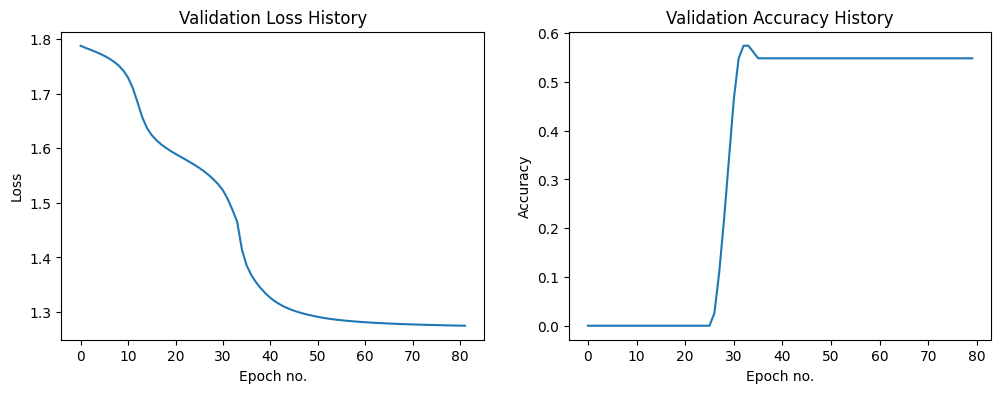

In [36]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

### Confusion matrix

In [46]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for input_ in test_dataloader:
    input_ = input_.to(device)
    out = model(*input_)
    output = F.log_softmax(out).argmax(dim=0)
    test_results.append(int(output.detach().cpu().numpy()))

In [51]:
label_to_id.keys()

dict_keys(['Missing_Cutting', 'Missing_Idle', 'Broken_Cutting', 'Healthy_Cutting', 'Healthy_Idle', 'Broken_Idle'])

In [56]:
list(label_to_id.keys())

['Missing_Cutting',
 'Missing_Idle',
 'Broken_Cutting',
 'Healthy_Cutting',
 'Healthy_Idle',
 'Broken_Idle']

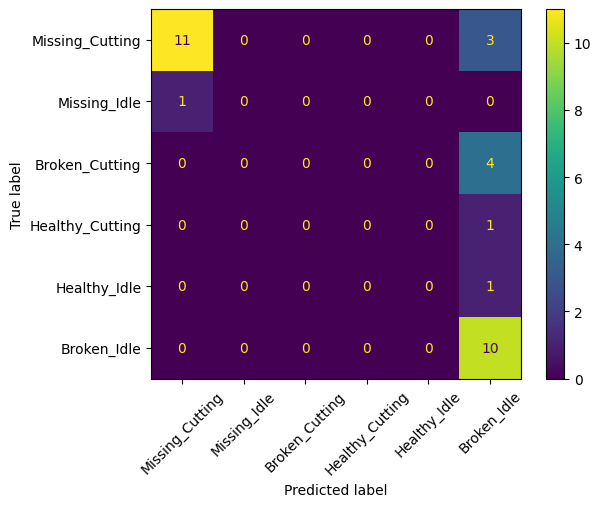

In [58]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_pred = [id_to_label[x] for x in test_results]
y_true = [train_labels[i].iloc[0] for i in range(len(train_labels))]

cm = confusion_matrix(y_true, y_pred, labels=list(label_to_id.keys()))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(label_to_id.keys()))

cm_display.plot()
plt.xticks(rotation = 45)
plt.show()